In [218]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

!!! You can run all cells and go the and of the notebook

### Dataset

In [220]:
PATH = "./data/"

In [221]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')



### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [222]:
## your code
data[data['Age'].isna() == True].shape[0]
temp1 = [ data[data[x].isna() == True].shape[0] for x in data ]
temp1_ = [x/data.shape[0]*100 for x in temp1]
temp1_
nan_feats_perc = dict(zip([x for x in data], temp1_))
nan_feats_perc

{'Survived': 0.0,
 'Pclass': 0.0,
 'Name': 0.0,
 'Sex': 0.0,
 'Age': 19.865319865319865,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Ticket': 0.0,
 'Fare': 0.0,
 'Cabin': 77.10437710437711,
 'Embarked': 0.22446689113355783}

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

There are only a few NaNs in 'Embarked', so we can either throw them out or replace them with the most common value (which is S).
'Age' is skipped in 19% of passengers. Since age has an almost normal distribution, I think it is possible to replace the NaNs with the average for each class.
'Cabin' has too many missing values. So, it cannot be dropped out, they cannot be replaced either, most likely. One can try to create a new feature that will simply show whether there is a cabin or not.

I will convert all categorical features into integers

In [223]:
# replace missing values in 'Embarked' with the most frequntly one

freq_port = data['Embarked'].dropna().mode()[0]
data['Embarked'] = data['Embarked'].fillna(freq_port)

# replace letters with numbers
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


In [224]:
# replace missing values with median value
data['Fare'].fillna(data['Fare'].dropna().median(), inplace=True)

In [225]:
# replace missing values in 'Age' with mean value for 'Sex' and 'Class'

df_age = data[['Pclass','Sex','Age']].copy()
gp_age = df_age.groupby(['Pclass','Sex']).size().reset_index()

for i in range(0,gp_age.shape[0]):
    mean = df_age[(df_age['Pclass'] == gp_age.iloc[i]['Pclass']) & (df_age['Sex'] == gp_age.iloc[i]['Sex'])]['Age'].mean()
    data.loc[(data['Age'].isnull()) & (data['Pclass'] == gp_age.iloc[i]['Pclass'])\
              & (data['Sex'] == gp_age.iloc[i]['Sex']), 'Age'] = mean
        

In [226]:
# replace 'Sex' with numbers

data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

Let's try to extract information from those features that, at first glance, do not affect at 'Survived'.

In [227]:
# let's extract the letter from Cabin number

data['CabinLetter'] = data['Cabin'].apply(lambda x: str(x)[0])

print(data['CabinLetter'].value_counts())

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinLetter, dtype: int64


In [228]:
# we also can replace thes letters with numbers and grouping them

title_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 7, "n": 7}
data['CabinLetter'] = data['CabinLetter'].map(title_mapping)


In [229]:
# create new feature 'is Cabin' from 'Cabin'

data['isCabin'] = 0
data.loc[data['Cabin'].notna(), 'isCabin'] = 1

In [230]:
# also we can try to extract personal titles from 'Name'
# let's process the personal titles from 'Name' the same way as in the 'CabinLetter'
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

data['Title'].value_counts()


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Sir           1
Ms            1
Mme           1
Capt          1
Don           1
Jonkheer      1
Lady          1
Name: Title, dtype: int64

In [231]:
data['Title'] = data['Title'].replace(['Dr','Rev','Col','Major','Countess','Sir',\
                                     'Lady', 'Capt','Jonkheer','Don','Dona'], 'Other')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

data['Title'].value_counts()


Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: Title, dtype: int64

In [232]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)

Features 'SibSp' and 'Parch' show whether the person traveled alone or not. Based on them, one can create a feature showing the number of family members, or a binary feature (whether the passenger traveled alone or not).

In [233]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['isAlone'] = 0
data.loc[data['FamilySize'] == 1, 'isAlone'] = 1

It turns out, there are many repeated tickets in 'Ticket'. One can make a feature, the value of which will correspond to the number of the same tickets, for instance.

In [234]:
tickets = data['Ticket'].value_counts()
tickets_ = tickets[tickets > 1]
print(tickets_)

data['Ticket_'] = 1
for i in range(0,tickets_.shape[0]):
    data.loc[(data['Ticket'] == tickets_.index[i]), 'Ticket_'] = tickets_[i]

1601        7
347082      7
CA. 2343    7
CA 2144     6
3101295     6
           ..
244367      2
113776      2
3101278     2
2653        2
239865      2
Name: Ticket, Length: 134, dtype: int64


We are faced with the task of classification, also many features are already categorical. Therefore, it makes sense to try to replace features with continuous values 'Fare' and 'Age' with categorical values.

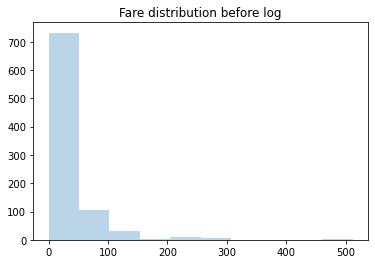

In [235]:
# but furst let's scale 'Fare', as it's distribution is not normal

plt.hist(data['Fare'], alpha = 0.3)
plt.title('Fare distribution before log')
plt.show()

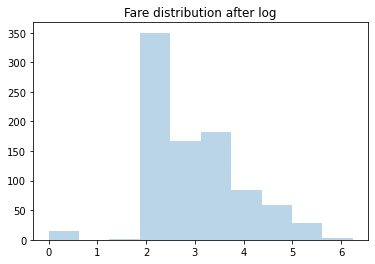

In [236]:
data['Fare'] = np.log(data['Fare']+1)

plt.hist(data['Fare'], alpha = 0.3)
plt.title('Fare distribution after log')
plt.show()

In [237]:
# dividing the entire range of values into intervals
data['FareBand'] = pd.qcut(data['Fare'], 6)
data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 2.172]",0.205128
1,"(2.172, 2.268]",0.190789
2,"(2.268, 2.738]",0.366906
3,"(2.738, 3.296]",0.436242
4,"(3.296, 3.977]",0.417808
5,"(3.977, 6.241]",0.697987


In [238]:
fb = data['FareBand'].unique().sort_values()
ind = []

for i in range(0, fb.shape[0]):
    ind_ = data.loc[(data['Fare'] > fb[i].left) & (data['Fare'] <= fb[i].right)].index
    ind.append(ind_)

for i in range(0,fb.shape[0]):
    data.loc[ind[i], 'Fare'] = i
    
data['Fare'] = data['Fare'].astype(int)


In [239]:
# the same processing for 'Age'

data['AgeBand'] = pd.cut(data['Age'], 7)
data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(0.34, 11.789]",0.573529
1,"(11.789, 23.157]",0.404545
2,"(23.157, 34.526]",0.313609
3,"(34.526, 45.894]",0.426829
4,"(45.894, 57.263]",0.411765
5,"(57.263, 68.631]",0.346154
6,"(68.631, 80.0]",0.142857


In [240]:
ab = data['AgeBand'].unique().sort_values(ascending=True)

for i in range(0,ab.shape[0]):
    data.loc[(data['Age'] > ab[i].left) & (data['Age'] <= ab[i].right), 'Age'] = i
    
data['Age'] = data['Age'].astype(int)


In [241]:
# drop unnecessary features
data = data.drop(['Name','Ticket','Cabin','FareBand','AgeBand'], axis=1)

In [242]:
print('final dataset:')
data

final dataset:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter,isCabin,Title,FamilySize,isAlone,Ticket_
PassengerId,,,,,,,,,,,,,,
1,0,3,0,1,1,0,0,0,7,0,1,2,0,1
2,1,1,1,3,1,0,5,1,3,1,3,2,0,1
3,1,3,1,2,0,0,1,0,7,0,2,1,1,1
4,1,1,1,3,1,0,5,0,3,1,3,2,0,2
5,0,3,0,3,0,0,1,0,7,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,2,0,0,2,0,7,0,5,1,1,1
888,1,1,1,1,0,0,4,0,2,1,2,1,1,1
889,0,3,1,1,1,2,3,0,7,0,2,4,0,2


In [243]:
#features = ['Pclass','Sex','Fare','Embarked','Title','Parch','isAlone','isCabin','Ticket_']

target = data['Survived']
#data = data.drop(['Survived', 'SibSp', 'Parch', 'Embarked', 'Title', 'CabinLetter', 'Ticket_', 'isAlone'], axis=1)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'isCabin', 'FamilySize', 'isAlone']
data = data[features]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=2020)

cv_ = 5

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)


X_train shape (712, 7)
y_train shape (712,)
X_test shape (179, 7)


In [244]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [245]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)
dt_clf.fit(X_train.values, y_train.values)
y_hat = dt_clf.predict(X_test.values)

In [246]:
print(f"Accuracy score is: {accuracy_score(y_test, y_hat)}")

Accuracy score is: 0.8156424581005587


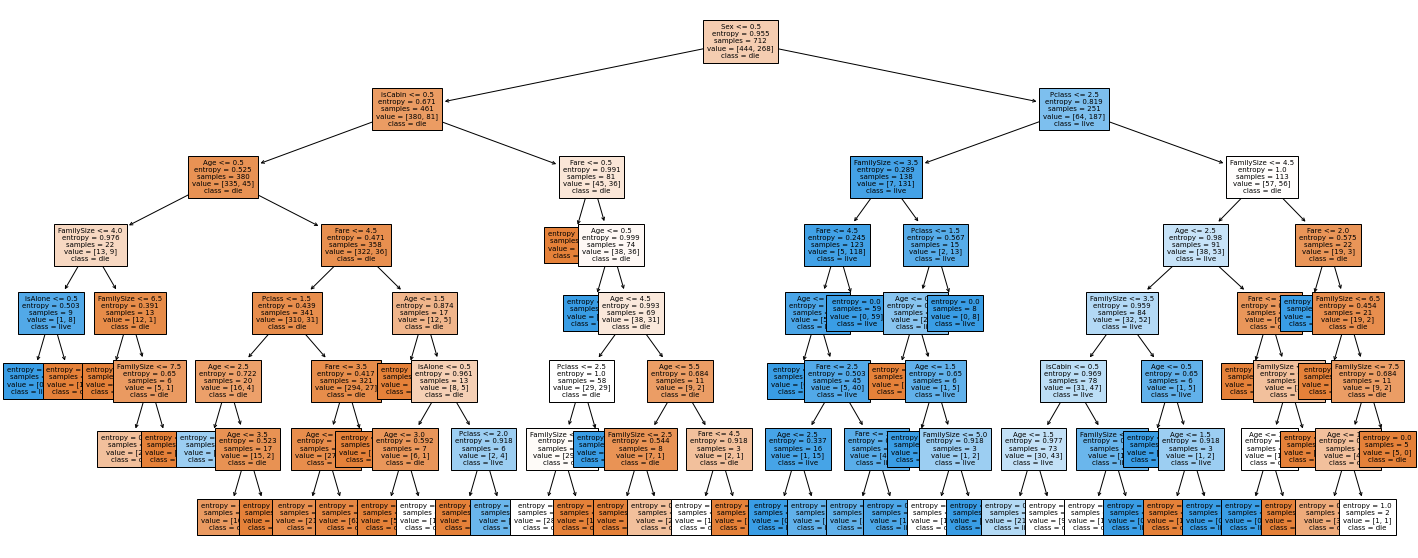

In [247]:
plt.figure(figsize=(25,10))
tree.plot_tree(dt_clf, fontsize=7, filled=True, feature_names = data.columns, class_names=['die','live'])
plt.show()

This tree can be intuitively interpreted to a depth of 2-4, I think. The root node divides all passengers by gender. As we remember, most of those deceased were men. This is immediately visible here (brown nodes corresponds to 'died', blue ones - to 'survived'). Further, on the side of men, end 'survived' nodes rarely come across, and they are scattered. On the women's side, the main criterion for division was 'Pclass'. On the right side is the result for women of the 3rd class, and, as you can see, there are many end 'died' nodes. The divisions by 'Age' and 'Fare' are also important. It can be seen that mostly young women survived (Age<=2.5), while women with very cheap tickets (Fare<=2.0) died.